In [29]:
import os
import sys
import pickle

import torch
from torch.utils.data import Dataset, DataLoader

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# turn off dark mode
plt.style.use('default')

from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)

In [22]:
with open("../train_dataset.pkl", "rb") as f:
    train_df: pd.DataFrame = pickle.load(f)['Adj Close']

train_df = train_df.fillna(method='ffill') # attempt to fill nan values
train_df = train_df.dropna(axis=1) #
train_df = train_df.pct_change(1)[1:]

assert pd.isna(train_df).any().sum() == 0

stocks = train_df.columns # stocks to keep without nan values

with open("../test_dataset.pkl", "rb") as f:
    test_df = pickle.load(f)['Adj Close']

test_df = test_df.pct_change(1)[1:]

assert pd.isna(test_df).any().sum() == 0

In [37]:
class ReturnWindowDataset(Dataset):
    def __init__(self, df, window_size) -> None:
        super().__init__()
        self.df = df
        self.w = window_size
    
    def __len__(self) -> int:
        return len(self.df) - self.w

    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
        X = train_df.iloc[index:index + self.w].values
        y = train_df.iloc[index + self.w].values
        
        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y).float()

        return X, y


In [38]:
device = "cuda:0"

dataset = ReturnWindowDataset(train_df, window_size=10)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

x,y = next(iter(dataloader))
x.shape, y.shape

(torch.Size([16, 10, 493]), torch.Size([16, 493]))

In [58]:
class Net(torch.nn.Module):
    def __init__(self, window_size, ) -> None:
        super().__init__()
        
        self.cnn_blocks = torch.nn.Sequential(
            torch.nn.Conv1d(window_size, 64, kernel_size=5, padding="same"),
            torch.nn.Tanh(),
            torch.nn.Conv1d(64, 128, kernel_size=5, padding="same"),
            torch.nn.Tanh(),
            torch.nn.Conv1d(128, 256, kernel_size=5, padding="same"),
            torch.nn.Tanh(),
            torch.nn.Conv1d(256, 512, kernel_size=5, padding="same"),
            torch.nn.Tanh(),
        )

        self.lin = torch.nn.Sequential(
            torch.nn.Linear(512, 128),
            torch.nn.ELU(),
            torch.nn.Linear(128, 32),
            torch.nn.ELU(),
            torch.nn.Linear(32, 1),
        )

    def forward(self, x):
        x = self.cnn_blocks(x)
        x = x.transpose(2,1)
        x = self.lin(x).squeeze()
        x = x / x.sum(dim=1).unsqueeze(1) # normalize weights, sum to 1
        return x


net = Net(10)
output = net(x)
output.shape

torch.Size([16, 493])

  0%|          | 0/7700 [00:00<?, ?it/s, epoch=1]

100%|██████████| 7700/7700 [02:49<00:00, 45.43it/s, epoch=100]


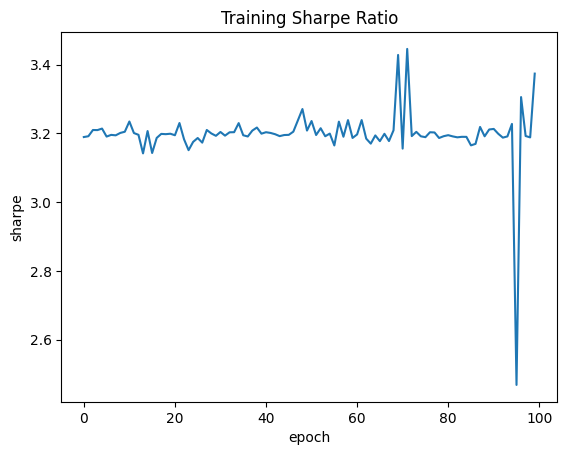

In [62]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001, maximize=True, weight_decay=0.1)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

EPOCHS = 100

net = Net(10)
net = net.to(device)
net.train()

targets = []

with tqdm(total=EPOCHS * len(dataloader), postfix={"epoch":0}) as progress:
    for epoch in range(EPOCHS):
        progress.set_postfix(epoch=(epoch + 1))
        s = []
        for i, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)

            # forward
            output = net(X)
            r = output * y
            sharpe_ratio = torch.mean(torch.std(r, dim=-1) / torch.mean(r, dim=-1))
            s.append(sharpe_ratio.item())

            # backward
            optimizer.zero_grad()
            sharpe_ratio.backward()
            optimizer.step()
            lr_sched.step()

            # print statistics
            # progress.set_postfix(R=R)
            progress.update()
        targets.append(sum(s) / len(s))

plt.figure()
plt.title("Training Sharpe Ratio")
plt.xlabel("epoch")
plt.ylabel("sharpe")
plt.plot(targets)
plt.show()

In [63]:
torch.save(net.state_dict(), "./cnn_1d_v1/net_cnn1d_weights.pth")

In [ ]:
import os
import sys
import json
import pickle
from glob import glob

import pandas as pd
import numpy as np
from mlp.network import RRNet
from portfolio import Portfolio

START_DATE = '2018-07-01'
END_TRAIN_DATE = '2023-05-31'
END_TEST_DATE = '2023-06-30'

def get_data():
    with open("dataset.pkl", "rb") as f:
        data = pickle.load(f)
    return data

def test_portfolio(strategy):
    print("Loading data...")
    full_train = get_data()
    returns = []
    # strategy = portfolio(weights_path)
    for test_date in pd.date_range(END_TRAIN_DATE, END_TEST_DATE):
        if test_date not in full_train.index:
            continue
        train = full_train[full_train.index < test_date]
        cur_portfolio = strategy.get_portfolio(train)
        if not np.isclose(cur_portfolio.sum(), 1):
            raise ValueError(f'The sum of the portfolio should be 1, not {cur_portfolio.sum()}')
        test_data = full_train['Adj Close'].loc[test_date].to_numpy()
        prev_test_data = train['Adj Close'].iloc[-1].to_numpy()
        test_data = test_data / prev_test_data - 1
        cur_return = cur_portfolio @ test_data
        returns.append({'date': test_date, 'return': cur_return})
    returns = pd.DataFrame(returns).set_index('date')
    mean_return, std_returns = np.mean(returns), np.std(returns)
    sharpe = float(mean_return / std_returns)
    print("Sharp Ratio: ", sharpe)

    # portfolio variance
    cov_matrix = full_train['Adj Close'].pct_change().cov()
    port_variance = np.dot(cur_portfolio.T, np.dot(cov_matrix, cur_portfolio))
    print("Portfolio Variance: ", port_variance)

    return sharpe, port_variance

if __name__ == '__main__':
    results = []

    models = glob("./experiments/*/*/*.pth")
    for model in models:
        model_dir = os.path.dirname(model)
        model_args = os.path.join(model_dir, "args.json")
        with open(model_args) as f:
            args = json.load(f)

        model_seed = args['seed']

        model_stocks = os.path.join(model_dir, "stocks.txt")
        with open(model_stocks) as f:
            stocks = f.readlines()
            stocks = [str(s).strip() for s in stocks]

        net = RRNet(dim=len(stocks), depth=args['depth']).eval()
        strategy = Portfolio(net, stocks, seed=model_seed)

        print("----------------------------------")
        print(model)
        try:
            s,v = test_portfolio(strategy)
            results.append({
                "model": model,
                "sharpe": s,
                "variance": v
            })
        except KeyboardInterrupt:
            exit(1)
        except:
            print("FAILED")

    results = pd.DataFrame(results).sort_values(by="sharpe", ascending=False)
    results.to_csv("results.csv", index=False)
